In [ ]:
# API que permite acceder a modelos preentrenados
%pip install transformers 
# Procesamiento de datos
%pip install pandas 
# Detector de lenguaje en un texto
%pip install langdetect 
# Uso de expresiones regulares
%pip install regex 
# Librería para procesamiento de lenguaje natural
%pip install nltk 
# Libería para análisis de sentimiento
%pip install pysentimiento
# Librería para generar histogramas
%pip install matplotlib
# Librería para arreglos
%pip install numpy
# Libería para usar OpenAI
%pip install openai
# Librería para datos del entorno (.env)
%pip install python-dotenv

In [4]:
import json
import math
import dotenv
import langdetect
import regex as re
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from transformers import pipeline
from matplotlib.ticker import PercentFormatter 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [7]:
# Abstracción de código que permite usar un modelo para inferencia (transformer)
classifier = pipeline('zero-shot-classification') 

# Clasificador en español
classifier_es = pipeline("zero-shot-classification", 
                       model="Recognai/bert-base-spanish-wwm-cased-xnli")

# Clasificador en español con un model más rápido
# classifier = pipeline("zero-shot-classification", 
#                      model="Recognai/zeroshot_selectra_medium")

In [ ]:
# No ejecutar esta celda, el resultado del preprocesado ya se encuentra en
# el archivo preprocessed_data.csv

# Se carga el dataset con Pandas
df = pd.read_csv('twitter_data.csv', lineterminator='\n')
df = df[['tweet']]

# Función que aplica un preprocesado básico en los tweets
# Quita saltos de línea, links, hashtags, arrobas y espacios extra
def preprocess(text):
    text = text.replace('\n', ' ')
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', '',text)
    text = re.sub('@[\w]+', '',text)
    re.sub("\s\s+", " ", text)
    if(str.isspace(text)):
        return ''
    return text

# Se aplica el preprocesado a cada tweet
df['tweet']= df['tweet'].apply(preprocess)

# Ya que hay unos tweets que quedan vacíos, porque se componían solo de hashtags,
# Se eliminan del dataframe
df['tweet'] = df['tweet'].replace('', np.nan)
df.dropna(inplace = True)

# Se exporta el dataframe preprocesado a un archivo csv
df.to_csv(path_or_buf='preprocessed_data.csv', columns = ['tweet'])

In [ ]:
# No ejecutar esta celda si no es necesario, su resultado es un nuevo csv 
# llamado tweets_eng_esp.csv que tiene una columna que almacena el
# lenguage de cada tweet. Solo se almacenan en inglés y español

# Entienda p_df como preprocessed_dataframe
p_df = pd.read_csv('preprocessed_data.csv', lineterminator='\n')

# Se crea una lista que contendrá el lenguaje detectado de cada texto
langs = []

# Función que identifica el lenguaje de un texto y adjunta el resultado a una lista
def get_langs(text):
    if len(langs) % 10000 == 0: print(len(langs))
    try:
        lang = langdetect.detect(text)
        if lang == 'en' or lang == 'es':
            langs.append(lang)
        else:
            langs.append('')
    except:
        langs.append('')

# Se aplica la identificación de lenguaje a cada tweet
p_df.rename(columns={"tweet\r": "tweet"}, inplace=True)
p_df['tweet'].apply(get_langs)

# Se insertan dichos lenguajes como una columna del DataSet
p_df.insert(1, 'lang', langs, allow_duplicates=True)

p_df['lang'] = p_df['lang'].replace('', np.nan)
p_df.dropna(inplace = True)
p_df.to_csv(path_or_buf='tweets_eng_esp.csv')

0


In [ ]:
# No correr esta línea, sus resultado se encuentra en un csv: 'outputs_esp_eng.csv','

df = pd.read_csv('tweets_eng_esp.csv', lineterminator='\n')

tweets_esp = df.loc[df['lang'] == 'es']
tweets_eng = df.loc[df['lang'] == 'en']

set_esp = tweets_esp['tweet\r'].values.tolist()
set_eng = tweets_eng['tweet\r'].values.tolist()

# Tema principal a identificar en los tweets (si no tratan sobre él, se descartan)
candidate_labels = ['Trump']

output_esp = []
output_eng = []

def output_generator(set, output):
    i = 1000 # Numero de Tweets para el histograma
    for elem in set:
        out = classifier_es(elem, candidate_labels, hypothesis_template='Este texto trata sobre {}')
        if out['scores'][0] > 0.1:
            i = i - 1
            output.append(elem)
        else: 
            continue
            
        if i == 0: 
            break    

output_generator(set_esp, output_esp)
output_generator(set_eng, output_eng)

# Se guardan los tweets (en español) que si hablan de Trump en un nuevo csv
outputs_esp_eng = pd.DataFrame(data = {'output_esp' : output_esp, 'output_eng': output_eng })
outputs_esp_eng.to_csv(path_or_buf='outputs_esp_eng.csv')

In [ ]:
# No correr esta línea, los histogramas se encuentran en histograms.csv
outputs_esp_eng = pd.read_csv('outputs_esp_eng.csv')
output_esp = outputs_esp_eng['output_esp'].values.tolist()

sentiment_labels = ['fuertemente en contra', 'en contra', 'imparcial', 'a favor', 'fuertemente a favor']

histogram_esp = [0.0, 0.0, 0.0, 0.0, 0.0]

results_esp = []

hypothesis = 'Esta persona está {} de la candidatura de Trump'

def histogram_maker(output, histogram):
    length = len(output)
    for tweet in output:
        analysis = classifier_es(tweet, sentiment_labels, hypothesis_template=hypothesis)
        index = sentiment_labels.index(analysis['labels'][0])
        histogram[index] += 1.0
        results_esp.append(tweet + ' ' + analysis['labels'][0])

    histogram = [elem / (length * 100) for elem in histogram]

histogram_maker(output_esp, histogram_esp)

In [65]:
# No correr esta línea, los histogramas se encuentran en histograms.csv
outputs_esp_eng = pd.read_csv('outputs_esp_eng.csv')
output_eng = outputs_esp_eng['output_eng'].values.tolist()

sentiment_labels = ['strongly against', 'against', 'neutral about', 'in favor', 'strongly in favor']

histogram_eng = [0.0, 0.0, 0.0, 0.0, 0.0]

results_eng = []
hypothesis = "This person is {} Trump's candidacy"

def histogram_maker(output, histogram):
    length = len(output)
    for tweet in output:
        analysis = classifier_es(tweet, sentiment_labels, hypothesis_template=hypothesis)
        index = sentiment_labels.index(analysis['labels'][0])
        histogram[index] += 1.0
        results_eng.append(tweet + ' ' + analysis['labels'][0])

    histogram = [elem / (length * 100) for elem in histogram]

histogram_maker(output_eng, histogram_eng)

In [68]:
# No correr esta línea, los histogramas se encuentran en histograms.csv
histograms = pd.DataFrame(data = {'histogram_esp' : histogram_esp, 'histogram_eng': histogram_eng })
histograms.to_csv(path_or_buf='histograms_transformers.csv')

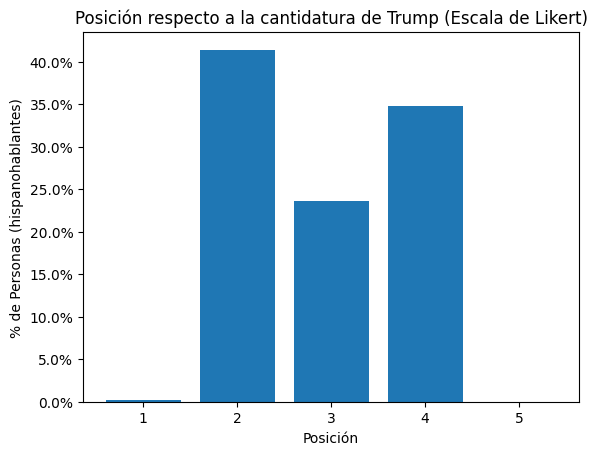

In [69]:
#Histograma de posiciones respecto a Trump de hispanohablantes (modelo rápido)
histograms = pd.read_csv('histograms_transformers.csv')
histogram_esp = histograms['histogram_esp'].values.tolist()

index = np.arange(len(histogram_esp)) 
labels = ['1', '2', '3', '4', '5']

plt.bar(index, histogram_esp) 
plt.title('Posición respecto a la cantidatura de Trump (Escala de Likert)')
plt.xlabel('Posición') 
plt.ylabel('% de Personas (hispanohablantes)') 
plt.xticks(index, labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1000))

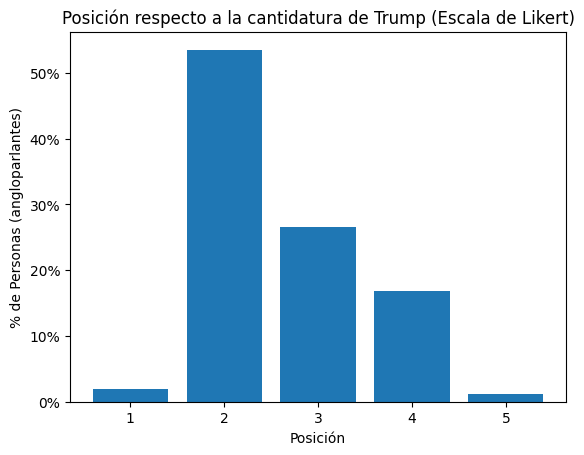

In [70]:
#Histograma de posiciones respecto a Trump de anglonoparlantes
histograms = pd.read_csv('histograms_transformers.csv')
histogram_eng = histograms['histogram_eng'].values.tolist()

index = np.arange(len(histogram_eng)) 
labels = ['1', '2', '3', '4', '5']

plt.bar(index, histogram_eng) 
plt.title('Posición respecto a la cantidatura de Trump (Escala de Likert)')
plt.xlabel('Posición') 
plt.ylabel('% de Personas (angloparlantes)') 
plt.xticks(index, labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1000))

In [ ]:
# Celda para verificar manualmente las opiniones sobre los datos. Usar results_esp para español
for result in results_esp:
    try:
        text = result.split('\r\n\r')
        tweet = text[0]
        opinion = text[1]
    except:
        text = result.split('\r')
        tweet = text[0]
        opinion = text[1]

    print('TWEET: ' + text[0])
    print('OPINION: ' + text[1] + '\n')

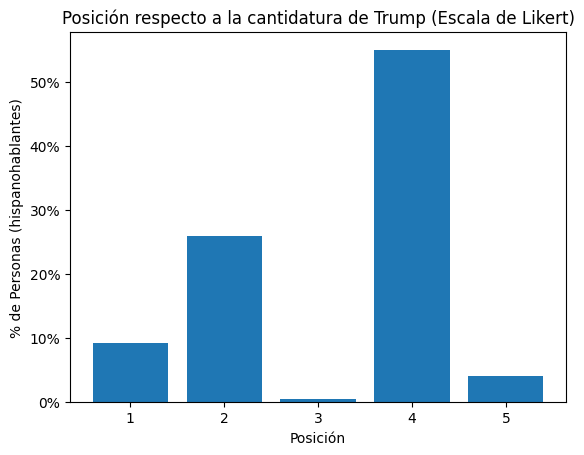

In [19]:
#Histograma de posiciones respecto a Trump de hispanohablantes (modelo lento)

index = np.arange(len(histogram_esp)) 
labels = ['1', '2', '3', '4', '5']

plt.bar(index, histogram_esp) 
plt.title('Posición respecto a la cantidatura de Trump (Escala de Likert)')
plt.xlabel('Posición') 
plt.ylabel('% de Personas (hispanohablantes)') 
plt.xticks(index, labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1000))